In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from time import time

# Face Recognition

In this challenge, we will
* use PCA to **compress black & white images of famous people**  
* use our compressed images as samples for a classification task

This time, contrary to the previous K-means challenge:

Instead of performing unsupervised learning on **one image** to find patterns **between its pixels** to reduce its unique color numbers, we will work on a dataset of **multiple B&W images** to:

- find common patterns **between all images**
- reduce the number of "principal features" that describe them

More precisely, we will try to express each image of our dataset as a **linear combination of principal components** (principal images in this case, if you will) using PCA.

To compress our images, we will then **zero out the smallest principal components** and keep only the most important ones in the equation. Each "reduced linear combination" will represent an image that has been compressed.  

Luckily, because we only removed the least important components, our lower-dimensional projection of the dataset will preserve the maximal data variance between images, so we should still be able to recognize which person is in each image.

## 1) Load Data

❓ Run the cell below to download a copy of the famous LFW dataset provided by `Sklearn`.

In [3]:
# Download data, should take around 2min
!curl https://wagon-public-datasets.s3-eu-west-1.amazonaws.com/05-Machine-Learning/06-Unsupervised-Learning/face_recognition/data.zip > data.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  191M  100  191M    0     0  12.8M      0  0:00:14  0:00:14 --:--:-- 13.9M


Once downloaded, the next cell will unzip the downloaded file into a `data` folder. It should look like this:

```bash
data
└── lfw_home
    ├── joblib
    ├── lfw
    ├── pairs.txt
    ├── pairsDevTest.txt
    └── pairsDevTrain.txt
```

In [4]:
!unzip -oq data.zip
!tree -L 2 data

data
└── lfw_home
    ├── joblib
    ├── lfw
    ├── pairsDevTest.txt
    ├── pairsDevTrain.txt
    └── pairs.txt

3 directories, 3 files


In [5]:
# from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(data_home='data', min_faces_per_person=70, resize=0.4, funneled=False)

💡 The **faces** object contains the following:
- `faces.images`: images as matrices of **50 x 37 pixels** you can plot 
- `faces.data`: flattened version of size **1850 x 1** *(50 x 37=1850)* 
- `faces.target`: number index representing a class among 7

❓ Run the cells below to check some basic facts about your data and see some images

In [6]:
print(f"- Images shape: {faces.images.shape}")
print(f"- Data (flattened images) shape: {faces.data.shape}")
print(f"- Target shape: {faces.target.shape}")
print(f"- Number of classes: {np.unique(faces.target).shape}")
print(f"- Each class is a famous person: {', '.join(faces.target_names)}")

- Images shape: (1288, 50, 37)
- Data (flattened images) shape: (1288, 1850)
- Target shape: (1288,)
- Number of classes: (7,)
- Each class is a famous person: Ariel Sharon, Colin Powell, Donald Rumsfeld, George W Bush, Gerhard Schroeder, Hugo Chavez, Tony Blair


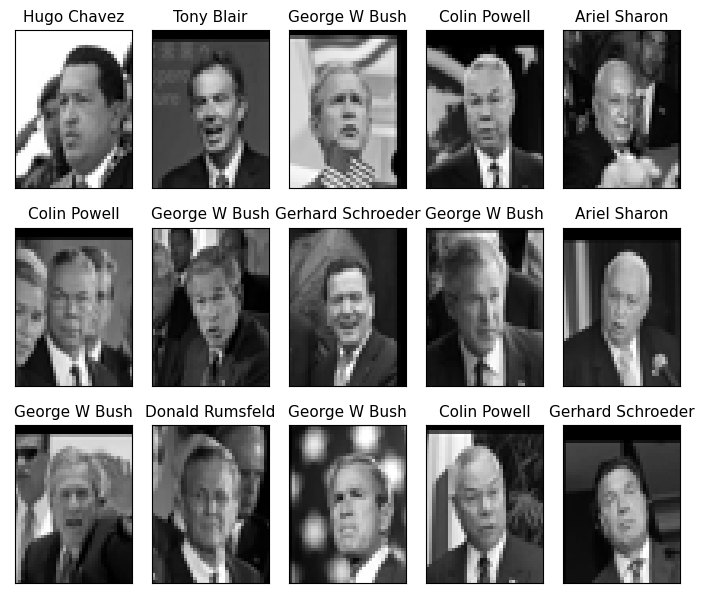

In [7]:
# Let’s see some faces.
fig = plt.figure(figsize=(7,10))

for i in range(15):
    plt.subplot(5, 5, i + 1)
    plt.title(faces.target_names[faces.target[i]], size=11)
    plt.imshow(faces.images[i], cmap=plt.cm.gray)
    plt.xticks(())
    plt.yticks(())

plt.tight_layout()

**Disclaimer**: we are aware that this dataset is not diverse at all and we apologize in advance. However, it is very well suited to understand PCA (low pixel count, B&W, only a few categories, faces well centered in the pictures, etc.) so please keep moving forward in this challenge to understand the notion of "principal component"!

## 2) Compression with PCA

We have **1288** observations (images) and **1850** features (50 × 37 pixels).

Having so many features for so few observations is not great in Machine Learning; as a rule of thumb, you may want at least: $n_{features} << \sqrt{n_{observations}}$.

**PCA** can help reduce these features to a more manageable size while maintaining most of the information in the data.


❓ Fit a `PCA` on your **flattened images** to reduce their dimensions to 150 components  
👉 Store your fitted `PCA` in a variable named **pca**  
👉 Then assign their transformation to **data_projected**

In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components=150)
data_projected = pca.fit_transform(faces.data)

The images were projected onto the first 150 principal components only. 

Again, what we call components are **directions of maximum variance** of the data. 

Now, we don't need 1850 pixels anymore to describe each image, but only 150 values 🤓  

A gain by factor of $\frac{1850}{150} = 12$ 🚀  

❓ Look at the shape of your components, and make sure you understand what it represents  
❓ Look at the shape of your first component, again make sure you understand what it represents  

In [9]:
pca.components_.shape

(150, 1850)

Your first component is a vector of 1850 values.  
We now have 150 components of 1850 values each.

One face is described as a linear combination of those components.

Let's reconstruct one image from its reduced representation to see how it works.

❓ Use `inverse_transform` on your **data_projected** to reconstruct your compressed images  
👉 Store the result in **data_reconstructed**

In [10]:
inverse_transform =  pca.inverse_transform(data_projected)

❓ Plot the 13th picture (George W. Bush) of the reconstructed dataset, and compare it with the original one. 

<details>
    <summary>💡Hint</summary>
Reshape the flattened data into an image of 50 x 37 pixels
</details>

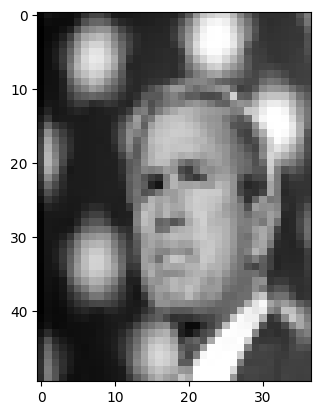

In [11]:
plt.imshow(faces.data[12].reshape(50, 37), cmap='gray')

❓ Run the cell below to see a selection of reconstructed images

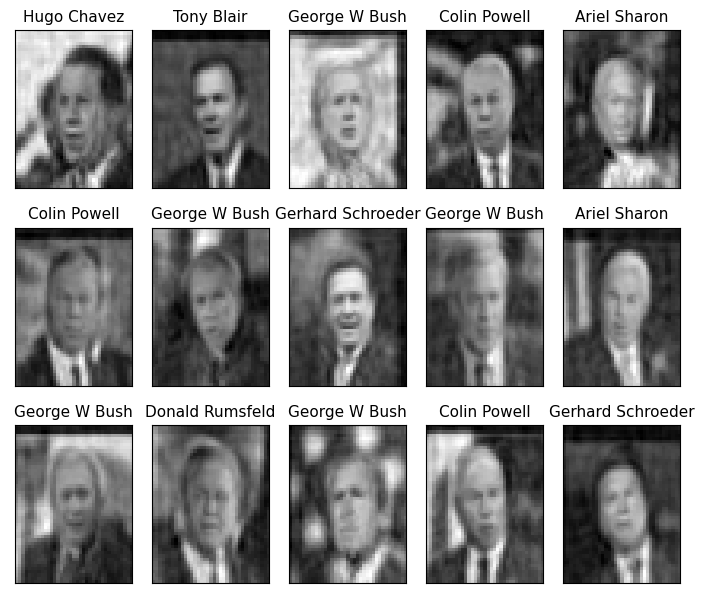

In [12]:
fig = plt.figure(figsize=(7, 10))

for i in range(15):
    plt.subplot(5, 5, i + 1)

    # Display each image with a title, which we grab from the dataset
    plt.title(faces.target_names[faces.target[i]], size=11)
    plt.imshow(pca.inverse_transform(data_projected)[i].reshape((50,37)), cmap=plt.cm.gray)

    # Remove plot ticks
    plt.xticks(())
    plt.yticks(())
    
plt.tight_layout()

### 🧪 Test your code

In [13]:
from nbresult import ChallengeResult

result = ChallengeResult('projection', shape=data_projected.shape)
result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.10.6, pytest-7.1.3, pluggy-1.0.0 -- /home/andreza/.pyenv/versions/3.10.6/envs/lewagon/bin/python
cachedir: .pytest_cache
rootdir: /home/andreza/code/andrezaumbelino/05-ML/09-Unsupervised-Learning/data-face-recognition/tests
plugins: typeguard-2.13.3, asyncio-0.19.0, anyio-3.6.2
asyncio: mode=strict
collecting ... collected 1 item

test_projection.py::TestProjection::test_shape PASSED                    [100%]

============================== 1 passed in 0.22s ===============================


💯 You can commit your code:

git add tests/projection.pickle

git commit -m 'Completed projection step'

git push origin master



## 3) Investigate your Principal Components

❓ Plot an image that corresponds to the *\"mean\"* face of the whole dataset  
👉 Use a `gray` color map for your plots in this section

<details>
    <summary>💡Hint</summary>
    
You can use `pca.mean_` or `faces.data.mean(axis=0)`  
You will also need some reshaping to be able to plot it as an image
</details>

❓ Plot the images corresponding to the **first 5** principal components  

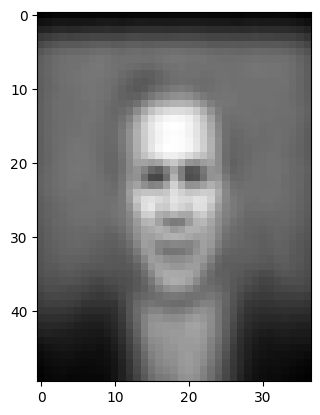

In [14]:
plt.imshow(pca.mean_.reshape(50, 37), cmap='gray')

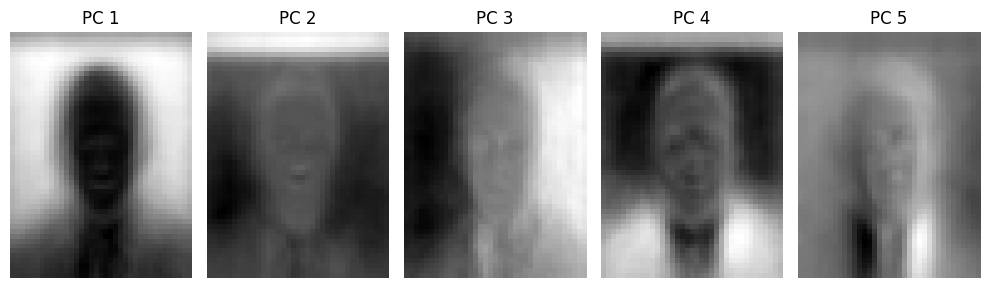

In [15]:
plt.figure(figsize=(10, 5))

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(pca.components_[i].reshape(50, 37), cmap='gray')
    plt.title(f"PC {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()

☝️ Each PC is a flattened "image" of 1850 pixels  
We merely reshaped them to be able to visualize them as normal images

👇 Below is a list of definitions of these Principal Components  

❓ **Read them carefully and make sure you understand them**, otherwise consider raising a ticket 🎟️ 

💡 Your first PCs are the **most important _directions_** on your 1850-feature observations

💡 They are the most important **_linear combinations_** of your 1850 pixels

💡 The ones which **preserve the most _variance_** when your dataset of pictures is projected onto them  

💡 The first few PCs are the **regions of the 2D pixel grid that contain the _most variation_** between your 1288 images

❓ Plot the images corresponding to the **last 5** principal components  

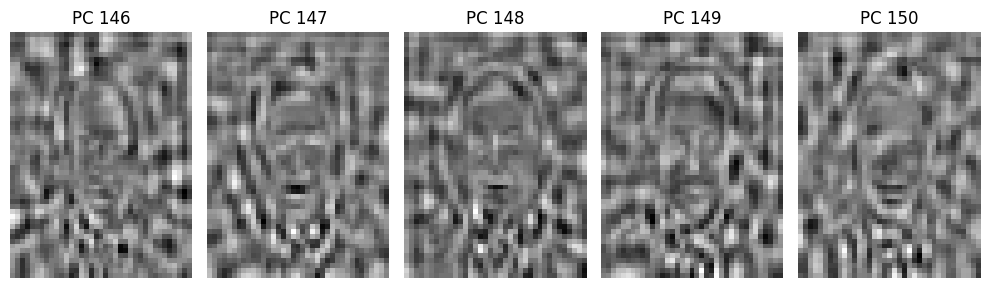

In [16]:
plt.figure(figsize=(10, 5))

for i in range(145, 150):  # Últimos 5 PCs
    plt.subplot(1, 5, i - 144)
    plt.imshow(pca.components_[i].reshape(50, 37), cmap='gray')
    plt.title(f"PC {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()

❓ Run the cell below to plot several images corresponding to principal components

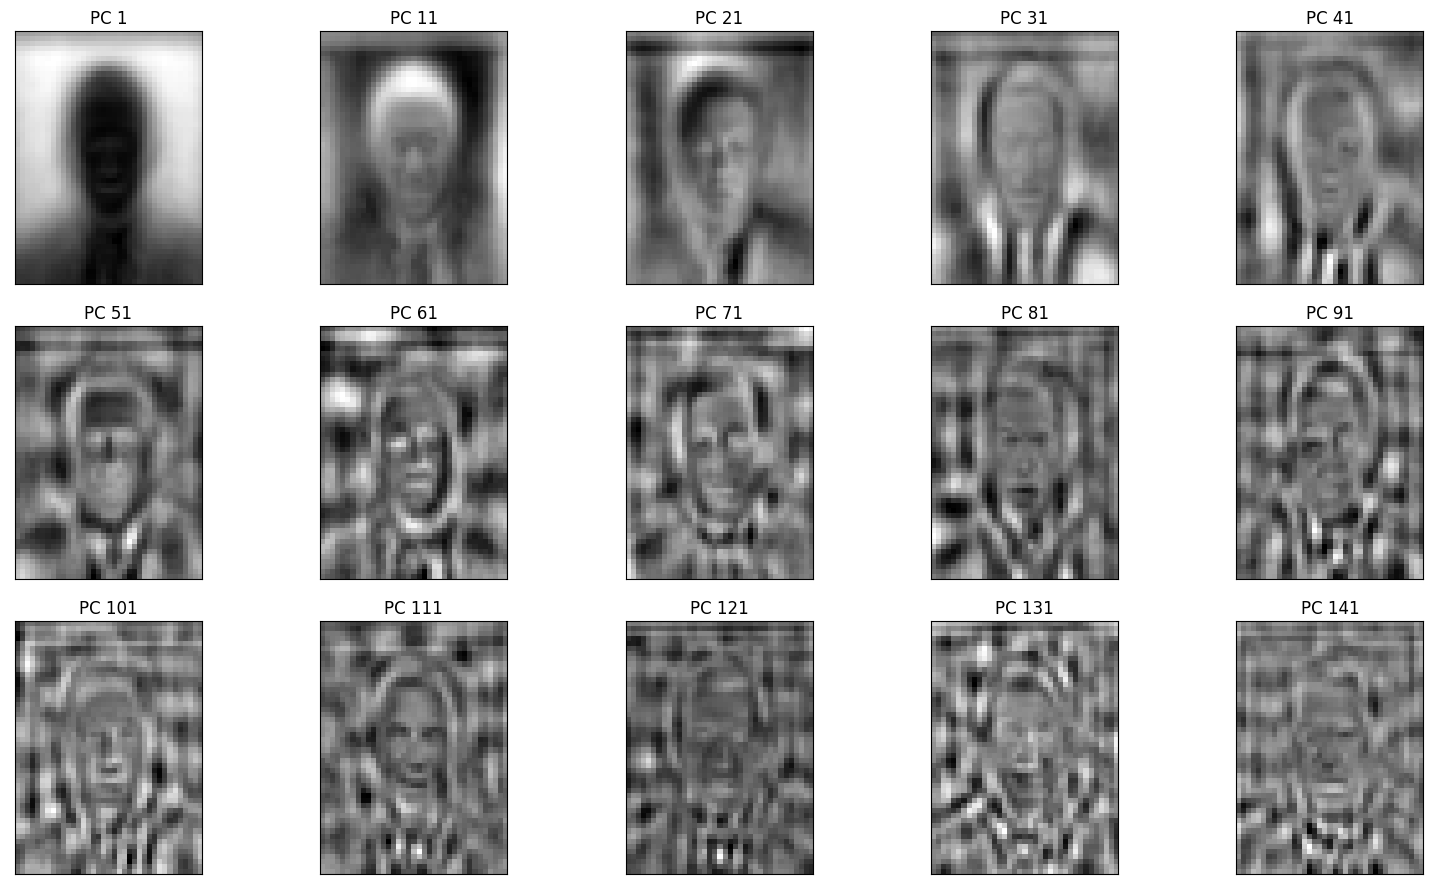

In [17]:
n_rows, n_cols = 3, 5
fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, 9))

for i in range(n_rows * n_cols):
    ax = axs[i // n_cols, i % n_cols]
    ax.set_title(f'PC {i * 10 + 1}', size=12)
    ax.set_xticks(()), ax.set_yticks(())
    ax.imshow(pca.components_[i * 10].reshape(50, 37), cmap='gray')

plt.tight_layout()

☝️ Take some time to look at the PCs and strengthen your intuition on what they represent  

Notice that the first PCs capture the biggest/simplest patterns that explain most of the difference between images:
- Orientation of the face: looking left, right, up, or down
- Size of the face, mouth, nose, and eyes

While the last PCs capture the smallest/most detailed patterns:
- The shape of the mouth (moving or still)
- The structure of the chin

Every image can be represented by the "mean face" plus a linear combination of the 150 "PC faces".

If you want to go further check the optional section **Reconstruction of an Original Image**.

## 4) Choose the Optimal Number of Components

We encounter, as is often the case in Machine Learning, a trade-off ⚖️

**Lots of components** will give a compressed image that is:  
🙂 Close to the original image in terms of quality  
🙁 Not significantly lighter than the original image

**A few components** will give a compressed image that is:  
🙂 Significantly lighter than the original
🙁 Far from the original image in terms of quality

It is very important to find how many components are needed to describe the data without losing too much information  

We can determine this visually by plotting the cumulative sum of explained variance ratio as a function of the number of components  

This information is stored in the `explained_variance_ratio_` attribute of a fitted `PCA` object from `sklearn`   

❓ Plot the cumulative sum of explained variance ratio against the number of components

In [18]:
explained_variance_ratio = pca.explained_variance_ratio_

In [19]:
explained_variance_ratio.shape

(150,)

In [20]:
cumulative_variance = np.cumsum(explained_variance_ratio)

In [21]:
cumulative_variance

array([0.27947962, 0.35052338, 0.40449378, 0.45183527, 0.49133906,
       0.51733303, 0.5420633 , 0.566228  , 0.58557886, 0.60324633,
       0.6190001 , 0.6327269 , 0.6458848 , 0.65721023, 0.6684591 ,
       0.67927253, 0.6889961 , 0.69767064, 0.7057058 , 0.7136687 ,
       0.72072214, 0.72761136, 0.7341673 , 0.740604  , 0.7468828 ,
       0.7527133 , 0.757925  , 0.7629806 , 0.76797915, 0.7724393 ,
       0.77665854, 0.78076833, 0.7847088 , 0.7885501 , 0.7923122 ,
       0.7959626 , 0.7995369 , 0.8029596 , 0.80626196, 0.80951613,
       0.81256676, 0.81550676, 0.8183329 , 0.82108736, 0.823798  ,
       0.8263785 , 0.82891816, 0.8313947 , 0.83378345, 0.83610845,
       0.8383193 , 0.8404967 , 0.8426488 , 0.84466845, 0.8466524 ,
       0.8485662 , 0.850436  , 0.8522901 , 0.85408133, 0.8558585 ,
       0.85760325, 0.859315  , 0.8609788 , 0.8626069 , 0.86420727,
       0.865773  , 0.86730754, 0.86881495, 0.8702635 , 0.8717076 ,
       0.8731365 , 0.8745105 , 0.87585896, 0.8771889 , 0.87850

In [22]:
x_range = np.arange(150)
x_range

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149])

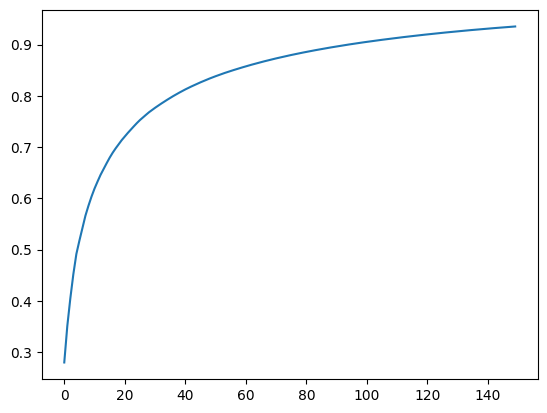

In [23]:
plt.plot(x_range, cumulative_variance)

☝️ This curve quantifies how much of the total variance is contained within the first components  

❓ Run the cell below and take some time to confirm the statements with your understanding of the graph:  
- The **first component** alone is enough to explain close to **20% of the variance**
- The first **25 components** are enough to explain close to **75% of the variance**
- We need about **94 components** to describe **90% of the variance**

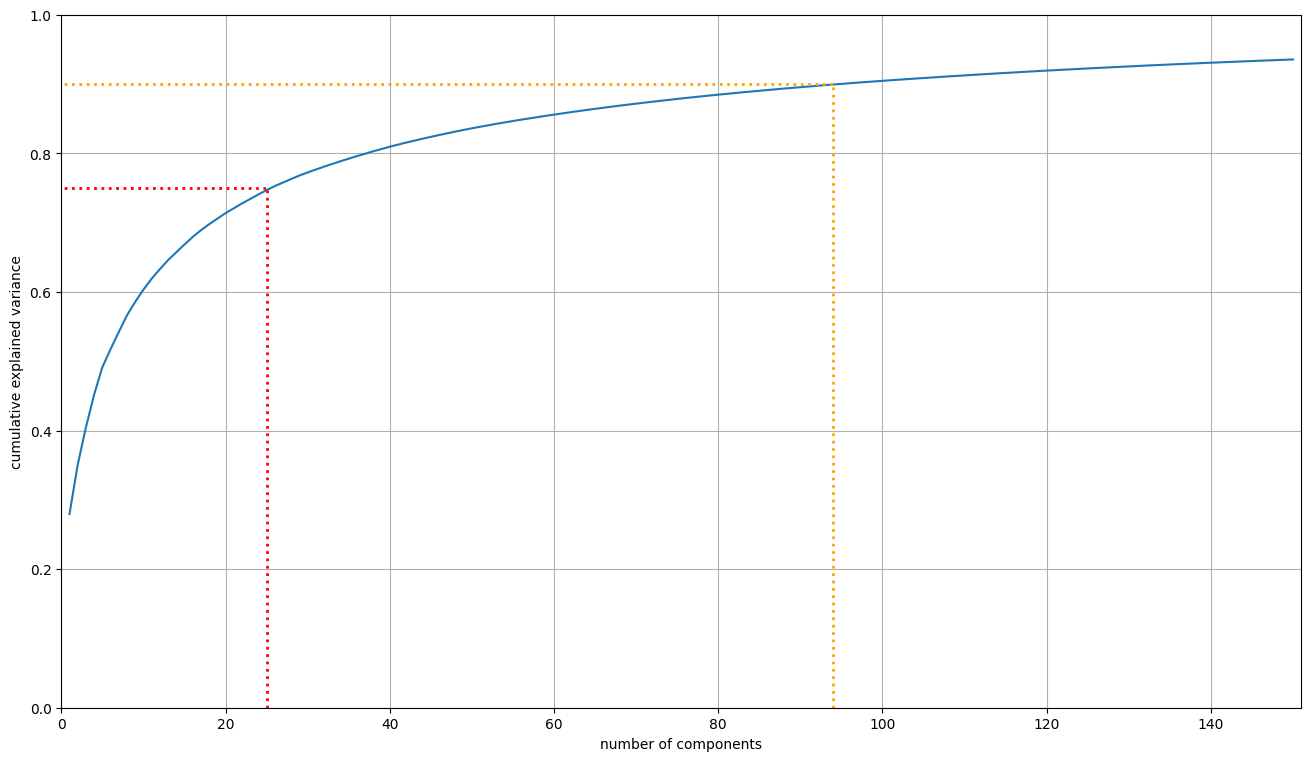

In [24]:
plt.figure(figsize=(16, 9))

# Plot the data
plt.plot(range(1, pca.n_components_+1), np.cumsum(pca.explained_variance_ratio_))

# Set labels
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

# Display grid in the background
plt.grid()

# Set the limits for the axes
plt.xlim((0, 151))
plt.ylim((0, 1))

# Add lines to the plot
plt.hlines(
    y=[.75, .9],
    xmin=[-5, -5],
    xmax=[25, 94],
    linestyles='dotted',
    colors=['red', 'orange'],
    linewidth=2
)
plt.vlines(
    x=[25, 94],
    ymin=[0, 0],
    ymax=[.75, .9],
    linestyles='dotted',
    colors=['red', 'orange'],
    linewidth=2
);

❓ What is the smallest number of components you need to keep to get _at least_ 80% of the variance?  
👉  Assign your answer to a variable named `minimal_pc_count`

In [25]:
minimal_pc_count = 39

### 🧪 Test your code

In [26]:
from nbresult import ChallengeResult

result = ChallengeResult('components', min_pc = minimal_pc_count)
result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.10.6, pytest-7.1.3, pluggy-1.0.0 -- /home/andreza/.pyenv/versions/3.10.6/envs/lewagon/bin/python
cachedir: .pytest_cache
rootdir: /home/andreza/code/andrezaumbelino/05-ML/09-Unsupervised-Learning/data-face-recognition/tests
plugins: typeguard-2.13.3, asyncio-0.19.0, anyio-3.6.2
asyncio: mode=strict
collecting ... collected 1 item

test_components.py::TestComponents::test_minimal_pc PASSED               [100%]

============================== 1 passed in 0.21s ===============================


💯 You can commit your code:

git add tests/components.pickle

git commit -m 'Completed components step'

git push origin master



## 5) Classify Images (PCA as Feature Engineering)

It is time to use **PCA** as a tool for **supervised ML**  .

Here is your brief 👇

Given a picture of the face of a famous person among a selection, your model should be able to tell to whom the face belongs.  

Translating this brief into ML terms 👇
- Your samples are images
- Your features are their pixels
- Your target is a class among several (7)

❓ Cross-validate a model of your choice, suited for the classification task at hand    
👉 Record the time needed to train and evaluate your model

<details span='markdown'>
    <summary>💡Hint </summary>
You can use the following method to record execution time:
    
```python
from time import time
start = time()
# CODE for which you want to record execution time
execution_time = time() - start
```
</details>

In [27]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from time import time


In [28]:
from time import time
start = time()
score = cross_val_score(LogisticRegression(max_iter=1000), data_projected, faces.target, cv=5).mean()
execution_time = time() - start

In [29]:
execution_time

0.4738733768463135

❓ Follow the same steps, this time using the projections of your images as features  

In [30]:
from time import time
start1 = time()
score1 = cross_val_score(LogisticRegression(max_iter=1000), faces.data, faces.target, cv=5).mean()
execution_time1 = time() - start1
execution_time1

17.797908544540405

👉 Compare your scores and execution times  

The quality of your model should have *slightly* decreased.  
The time needed to *\"choose\"* (train and evaluate) the model, however, should have *greatly* decreased!

From a business point of view, this is a great achievement 🏆  
As you will discover during the ML Ops module, training models comes at a cost 💸🙈

## 6) Search for the Optimal Number of Components

*This time, the Machine Learning way: Grid Search*.

💡 Now that we have a supervised (features-target) ML setting, we can grid search the optimal number of components.

❓ Before proceeding, hold out 30% of your data as a test set  

👉 As usual, assign your split data to `X_train`, `X_test`, `y_train`, `y_test`  
👉 In your `train_test_split`, use `random_state=42` to compare results with your buddy

💡 We will **select** our model by **cross-validating** on the **train set**  
Then we will **assess** our model by **scoring** it on the **test set**

In [35]:
X_train, X_test, y_train, y_test = train_test_split(faces.data, faces.target, test_size=0.3, random_state=42)


In [36]:
pipe = make_pipeline(
PCA(),
LogisticRegression(max_iter=1000)
)

In [37]:
pipe.get_params()['steps'] 

[('pca', PCA()), ('logisticregression', LogisticRegression(max_iter=1000))]

In [46]:
from sklearn.model_selection import GridSearchCV

param_grid = {
  'pca__n_components': range(10, 100, 10),
  }



search = GridSearchCV(pipe, param_grid, scoring='accuracy', cv=5)
search.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pca', PCA()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'pca__n_components': [50, 100, 200, 300]},
             scoring='accuracy')

In [47]:
search.best_params_

{'pca__n_components': 300}

In [41]:
search.best_score_

0.6182013505217925

💡 A grid search calls for a pipeline  
❓ Use [`make_pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html) to create a pipeline with two steps:
- A `PCA`, no need to choose the number of components now
- The [`SVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) algorithm as an estimator

In [56]:
pipe2 = make_pipeline(
    PCA(),
    SVC(),
    
)

In [57]:
pipe2.get_params()['steps'] 

[('pca', PCA()), ('svc', SVC())]

In [58]:
param_grid2 = {
  'pca__n_components': [50, 100, 200, 300],
   'svc__C': [0.1, 1, 10],
    'svc__kernel': ['linear', 'rbf']
  }

In [59]:
search2 = GridSearchCV(pipe2, param_grid2, scoring='accuracy', cv=5)

In [62]:
search2.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Pipeline(steps=[('pca', PCA()), ('svc', SVC())]),
             param_grid={'pca__n_components': [50, 100, 200, 300],
                         'svc__C': [0.1, 1, 10],
                         'svc__kernel': ['linear', 'rbf']},
             scoring='accuracy')

❓ Create a cross-validated grid search that uses your pipeline  
👉 Search only for the number of components for your `PCA` among these options: `[50, 100, 200, 300]`  

In [60]:
cross_val_score(pipe2, faces.data, faces.target, cv=5).mean()

0.5396193406328236

❓ Print the [classification report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report) of your best model  
👉 Use the `best estimator` from your grid search to obtain predictions from **X_test**  
👉 Use these predictions against **y_test** to print your classification report

In [67]:
search2.best_score_

0.6659545733578882

In [63]:
search2.best_params_

{'pca__n_components': 300, 'svc__C': 0.1, 'svc__kernel': 'linear'}

You may get an UndefinedMetricWarning if for one of the classes, there are no correct predictions.

❓ How many components give the best score?  
👉 Assign the value to a variable named **best_n_components**

In [65]:
best_n_components = 300

### 🧪 Test your code

In [66]:
from nbresult import ChallengeResult

result = ChallengeResult('search_components', best_pc=best_n_components)
result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.10.6, pytest-7.1.3, pluggy-1.0.0 -- /home/andreza/.pyenv/versions/3.10.6/envs/lewagon/bin/python
cachedir: .pytest_cache
rootdir: /home/andreza/code/andrezaumbelino/05-ML/09-Unsupervised-Learning/data-face-recognition/tests
plugins: typeguard-2.13.3, asyncio-0.19.0, anyio-3.6.2
asyncio: mode=strict
collecting ... collected 1 item

test_search_components.py::TestSearchComponents::test_best_pc_number PASSED [100%]

============================== 1 passed in 1.41s ===============================


💯 You can commit your code:

git add tests/search_components.pickle

git commit -m 'Completed search_components step'

git push origin master



## 7) What about Scaling, Balancing and Tuning?

*The complete Machine Learning pipeline*

We focused extensively on PCA but there are 3 ML methods you can use to enhance your score:
- Scale your data before applying PCA
- Use some form of balancing as your classes are not balanced
- Grid search for optimal hyperparameters for your estimator

Let's do it and see how using `PCA` alongside the ML tricks we have seen so far will help us achieve a higher score

❓ Run the cell below to see both your baseline and base score obtained with only PCA + SVC

In [69]:
X = faces.data
y = faces.target

In [75]:
baseline = pd.Series(y).value_counts(normalize=True).max()

score_base = cross_validate(
    make_pipeline(
        PCA(n_components=best_n_components),
        SVC()
    ),
    X, y,
    scoring='accuracy',
    cv=3,
    n_jobs=-1
)


score_base

{'fit_time': array([0.29574299, 0.3074038 , 0.29517007]),
 'score_time': array([0.06920767, 0.06620383, 0.06920743]),
 'test_score': array([0.52790698, 0.48951049, 0.54312354])}

In [74]:
score_base['test_score'].mean()


0.5201803364594063

In [ ]:
print(f"""
    Accuracy scores:
    Baseline (frequency of most frequent class): {baseline: .2%}
    Base Model (PCA + SVC): {score_base:.2%}
""")

### Scaling

❓ Scale your data before reduction with a `PCA`  
👉 Build a pipeline that has 3 steps:
- Scaling with `StandardScaler`
- Reduction with `PCA` (use **best_n_components** from your earlier search)
- Prediction with `SVC` (keep all default arguments)

In [77]:
score_base2 = cross_validate(
    make_pipeline( 
        StandardScaler(),
        PCA(n_components=best_n_components),
        SVC()
    ),
    X, y,
    scoring='accuracy',
    cv=3,
    n_jobs=-1
)
score_base2

{'fit_time': array([0.33745956, 0.37138677, 0.37133503]),
 'score_time': array([0.06714916, 0.06754994, 0.06288338]),
 'test_score': array([0.63255814, 0.58741259, 0.65501166])}

In [80]:
score_scaling2 = score_base2['test_score'].mean()

❓ Cross-validate your pipeline on the full **X** and **y** over 3 folds  
👉 Store the mean score in **score_scaling**  
👉 Check your new score

In [81]:
score_scaling2

0.6249941273197087

☝️ Up we go

### Balancing

❓ Check the spread of your target classes

In [82]:
pd.Series(y).value_counts(normalize=True)

3    0.411491
1    0.183230
6    0.111801
2    0.093944
4    0.084627
0    0.059783
5    0.055124
dtype: float64

☝️ As you can see, your classes are highly unbalanced  

The most represented class appears on 41% of images  
While the least represented one appears on 5.5% of images  

This will cause your model to predict the most represented class too often, which will decrease
- the precision score for the most represented classes 
- the recall score for the least represented classes

❓ Train another pipeline that takes into account your class imbalance  
👉 Check the [documentation of the SVC estimator](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)  
👉 Find and use the parameter that helps with the class imbalance in your SVC  
👉 Store the mean score in **score_balanced** and check your new score

In [83]:
score_base3 = cross_validate(
    make_pipeline( 
        StandardScaler(),
        PCA(n_components=best_n_components),
        SVC(class_weight='balanced')
    ),
    X, y,
    scoring='accuracy',
    cv=3,
    n_jobs=-1
)
score_base3

{'fit_time': array([0.30161071, 0.31551218, 0.31044006]),
 'score_time': array([0.07217097, 0.07120109, 0.07145786]),
 'test_score': array([0.68604651, 0.6037296 , 0.68531469])}

In [85]:
score_scaling3 = score_base3['test_score'].mean()
score_scaling3

0.6583636002240653

🚀 Sky is the limit

### Fine-Tuning

❓ Fine-tune your model to find the combination of hyperparameters that yields the highest score  
👉 Search 3 hyperparameters maximum  
👉 For each one, search on 3 values maximum  
👉 Here is an indicative search dictionary you can use:
```python
grid = {
        'svc__kernel': ['rbf', 'poly', 'sigmoid'],
        'svc__gamma': [1e-4, 1e-3, 1e-2],
        'svc__C': [10, 1e2, 1e3]
}
```
ℹ️ These ranges of hyperparameters are examples and are not meant to offer the combination for the best model. Feel free to change the values!

In [87]:
pipe_balanced = make_pipeline( 
        StandardScaler(),
        PCA(n_components=best_n_components),
        SVC(class_weight='balanced')
    )

In [88]:
grid = {
    'svc__kernel': ['rbf', 'poly', 'sigmoid'],
    'svc__gamma': [1e-4, 1e-3, 1e-2],
    'svc__C': [10, 1e2, 1e3]
}

search = GridSearchCV(
    pipe_balanced, 
    grid,
    cv=3,
    scoring='accuracy'
)

search.fit(X, y)
score_tuned = search.best_score_
round(score_tuned, 5)

0.76939

In [90]:
score_balanced = 0.76939

🚀 We increased accuracy by 10 points compared to our base model  

With a dimensionality reduction technique, such as `PCA`, it is faster to train, cross-validate and fine-tune our models  

Fine-tuning can be extremely long, being able to speed up the process by using a reduction on our data beforehand is a great advantage

### 🧪 Test your code

In [91]:
from nbresult import ChallengeResult

result = ChallengeResult(
    'full_pipeline',
    score_scaled=score_scaling,
    score_balanced=score_balanced,
    score_tuned=score_tuned
)

result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.10.6, pytest-7.1.3, pluggy-1.0.0 -- /home/andreza/.pyenv/versions/3.10.6/envs/lewagon/bin/python
cachedir: .pytest_cache
rootdir: /home/andreza/code/andrezaumbelino/05-ML/09-Unsupervised-Learning/data-face-recognition/tests
plugins: typeguard-2.13.3, asyncio-0.19.0, anyio-3.6.2
asyncio: mode=strict
collecting ... collected 3 items

test_full_pipeline.py::TestFullPipeline::test_score_balancing PASSED     [ 33%]
test_full_pipeline.py::TestFullPipeline::test_score_fine_tuned PASSED    [ 66%]
test_full_pipeline.py::TestFullPipeline::test_score_scaling PASSED       [100%]

============================== 3 passed in 0.80s ===============================


💯 You can commit your code:

git add tests/full_pipeline.pickle

git commit -m 'Completed full_pipeline step'

git push origin master



🏁 **Don't forget to push your notebook.**  

Proceed with the challenges of the day and come back here if you have time 😉

<details>
  <summary markdown='span'>🍔 Food for thought</summary>

You can try to compare the result of the PCA-preprocessed classification with the one that was not preprocessed to see if
1. it is quicker
2. it is better
3. it helps find a linear separation
</details>

## 8) (Optional) Reconstruction of an Original Image

👉 Study the cells below which reconstruct the image step by step without `inverse_transform`  

👉 We start by selecting a single image for the example

In [ ]:
# Let's reconstruct the 13th image
image_original = faces.images[12];
image_compressed = data_projected[12];

plt.imshow(image_original, cmap='gray');

👉 We manually do the sum of multiplications $X\_reconstructed_{i} = \sum_{i=1}^{n\_components}{X_{projected_i} * W_i}$  
$W_i$ being the `i-th principal component`  

In [ ]:
# We start the reconstruction from the mean of all images
image_reconstructed = pca.mean_.copy(); 

# Then, reconstruct the image by computing the sum of every 150 entries of its compressed representation, weighted by the corresponding principal components
reconstruction = list()

for i in range(pca.n_components_):
    image_reconstructed += pca.components_[i] * image_compressed[i]
    reconstruction.append(image_reconstructed.copy())

👉 We plot the reconstructed image alongside the original

In [ ]:
# Plot the original and the compressed image.
fig, ax = plt.subplots(1, 2, figsize = (5, 5))

# Original
ax[0].imshow(image_original, cmap='gray')
ax[0].set_title('Original Image')

# Reconstructed
ax[1].imshow(image_reconstructed.reshape(faces.images[0].shape), cmap='gray')
ax[1].set_title('Compressed reconstructed Image')

for ax in fig.axes:
    ax.axis('off')

plt.tight_layout()

👉 We plot the image at different steps of reconstruction

In [ ]:
# Plot several images at different steps of reconstruction
n_rows, n_cols = 3, 5
fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, 9))
plt.suptitle('Image reconstructed using only...')

for i in range(n_rows * n_cols):
    ax = axs[i // n_cols, i % n_cols]
    ax.set_title(f'... {i * 10 + 1} PC', size=12)
    ax.set_xticks(()), ax.set_yticks(())
    ax.imshow(reconstruction[i * 10].reshape(50, 37), cmap='gray')

plt.tight_layout()